[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/niteshjindal-7/unsupervised-learning/blob/main/Challenge_LLM_for_Insurance_Claim_Automation/code/Mdl1_Fine_tune_BERT.ipynb)



## Import Modules

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import transformers
from transformers import BertModel
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import Dataset
# from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
print("Transformer Module Version", transformers.__version__)
# !pip install evaluate
import evaluate
import os
import natsort
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time
from torch.optim import AdamW
from tqdm.auto import tqdm

Transformer Module Version 4.15.0


2023-07-07 15:06:18.500635: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
%pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org gdown==4.2.0
import gdown
import warnings
warnings.filterwarnings("ignore")
# Load digit-recognizer (Train Data)
url = 'https://drive.google.com/uc?id=1Vc02g2yJ2GnKv0siLIVpvq9eGKeDcPgi'
output = 'insurance_claims.csv'
gdown.download(url, output, quiet=False, verify=False)


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Downloading...
From: https://drive.google.com/uc?id=1Vc02g2yJ2GnKv0siLIVpvq9eGKeDcPgi
To: /home/nitesh/Desktop/Challenge_LLM_for_Insurance_Claim_Automation/code/insurance_claims.csv
100%|██████████████████████████████████████| 24.1M/24.1M [00:03<00:00, 6.28MB/s]


'insurance_claims.csv'

## Utility Function 

In [2]:
def evaluate(model, data_loader):
    predictions = []
    true_labels = []

    # Set the model in evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predicted labels
            predicted = torch.argmax(logits, dim=-1)

            predictions.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Calculate classification report
    classification_rep = classification_report(true_labels, predictions, digits=3)

    return classification_rep


def export_classification_report(report, mod, exec_time, eval_set=None):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    

    acc = float(data[3][1])
    m_prec = float(data[4][2])
    m_recall = float(data[4][3])
    m_f1 = float(data[4][4])
    w_prec = float(data[5][2])
    w_recall = float(data[5][3])
    w_f1 = float(data[5][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'EvalSet': [eval_set],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
        'Runtime': [exec_time]
    })
    
    return df

## Data Loading, Model Training and Performance Evaluation

Claim Categories: ['property' 'auto' 'health']
Training dataset size: 19200
Validation dataset size: 4800
Test dataset size: 6000


/tmp/ipykernel_17582/246396310.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['encoded_label'] = labelencoder.fit_transform(train['label'])
/tmp/ipykernel_17582/246396310.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['encoded_label'] = labelencoder.fit_transform(val['label'])
/tmp/ipykernel_17582/246396310.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

train encodings shape  torch.Size([19200, 12])
validation encodings shape  torch.Size([4800, 12])
test encodings shape  torch.Size([6000, 12])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.1183, Val Loss: 0.0835
Epoch 2/2, Train Loss: 0.0786, Val Loss: 0.0832
Execution time: 160.02649307250977 seconds


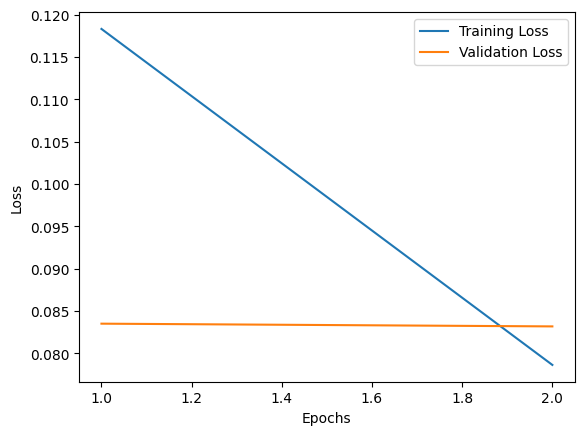

Train Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.882     0.937      6484
           1      0.875     1.000     0.933      6359
           2      1.000     0.977     0.988      6357

    accuracy                          0.953     19200
   macro avg      0.958     0.953     0.953     19200
weighted avg      0.958     0.953     0.953     19200


Validation Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.876     0.934      1646
           1      0.870     1.000     0.930      1582
           2      1.000     0.979     0.989      1572

    accuracy                          0.951      4800
   macro avg      0.957     0.952     0.951      4800
weighted avg      0.957     0.951     0.951      4800


Test Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.882     0.938      2050
           1      0.8

/tmp/ipykernel_17582/246396310.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['encoded_label'] = labelencoder.fit_transform(train['label'])
/tmp/ipykernel_17582/246396310.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['encoded_label'] = labelencoder.fit_transform(val['label'])
/tmp/ipykernel_17582/246396310.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

train encodings shape  torch.Size([19200, 12])
validation encodings shape  torch.Size([4800, 12])
test encodings shape  torch.Size([6000, 12])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.1114, Val Loss: 0.0753
Epoch 2/2, Train Loss: 0.0795, Val Loss: 0.0759
Execution time: 163.1195638179779 seconds


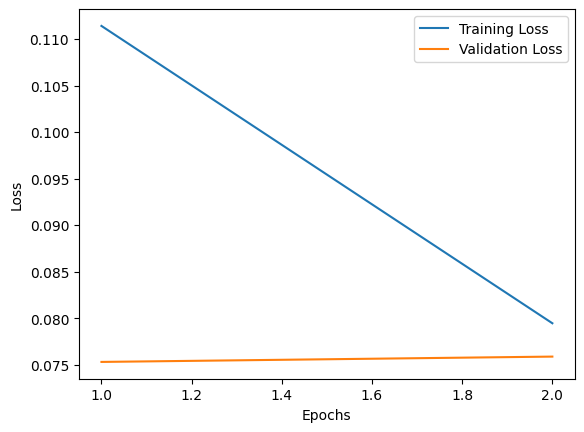

Train Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.881     0.937      6506
           1      0.875     1.000     0.933      6374
           2      1.000     0.978     0.989      6320

    accuracy                          0.953     19200
   macro avg      0.958     0.953     0.953     19200
weighted avg      0.958     0.953     0.953     19200


Validation Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.881     0.936      1641
           1      0.867     1.000     0.929      1542
           2      1.000     0.975     0.987      1617

    accuracy                          0.951      4800
   macro avg      0.956     0.952     0.951      4800
weighted avg      0.957     0.951     0.951      4800


Test Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.882     0.937      2033
           1      0.8

/tmp/ipykernel_17582/246396310.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['encoded_label'] = labelencoder.fit_transform(train['label'])
/tmp/ipykernel_17582/246396310.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['encoded_label'] = labelencoder.fit_transform(val['label'])
/tmp/ipykernel_17582/246396310.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

train encodings shape  torch.Size([19200, 12])
validation encodings shape  torch.Size([4800, 12])
test encodings shape  torch.Size([6000, 12])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.1260, Val Loss: 0.0816
Epoch 2/2, Train Loss: 0.0788, Val Loss: 0.0843
Execution time: 178.2307243347168 seconds


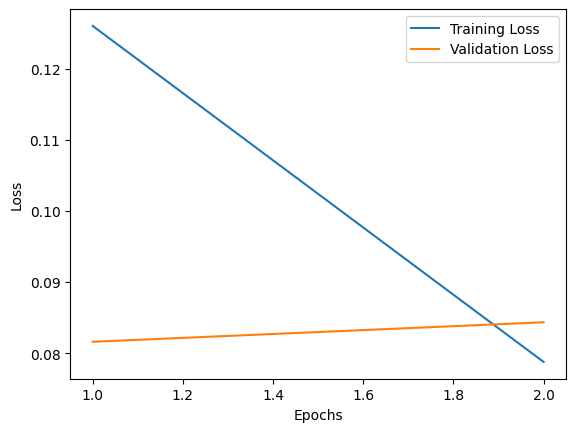

Train Data Classification Report:
              precision    recall  f1-score   support

           0      0.867     1.000     0.929      6490
           1      1.000     0.866     0.928      6355
           2      1.000     0.978     0.989      6355

    accuracy                          0.948     19200
   macro avg      0.956     0.948     0.949     19200
weighted avg      0.955     0.948     0.948     19200


Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.848     1.000     0.918      1612
           1      1.000     0.844     0.915      1594
           2      1.000     0.976     0.988      1594

    accuracy                          0.940      4800
   macro avg      0.949     0.940     0.940      4800
weighted avg      0.949     0.940     0.940      4800


Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.868     1.000     0.930      2078
           1      1.0

/tmp/ipykernel_17582/246396310.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['encoded_label'] = labelencoder.fit_transform(train['label'])
/tmp/ipykernel_17582/246396310.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['encoded_label'] = labelencoder.fit_transform(val['label'])
/tmp/ipykernel_17582/246396310.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

train encodings shape  torch.Size([19200, 12])
validation encodings shape  torch.Size([4800, 12])
test encodings shape  torch.Size([6000, 12])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.1092, Val Loss: 0.0676
Epoch 2/2, Train Loss: 0.0794, Val Loss: 0.0666
Execution time: 188.00685930252075 seconds


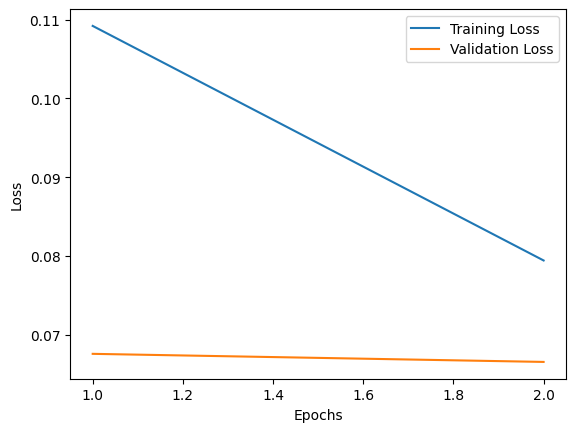

Train Data Classification Report:
              precision    recall  f1-score   support

           0      0.943     0.922     0.933      6536
           1      0.923     0.966     0.944      6346
           2      1.000     0.977     0.988      6318

    accuracy                          0.955     19200
   macro avg      0.956     0.955     0.955     19200
weighted avg      0.955     0.955     0.955     19200


Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.954     0.932     0.943      1639
           1      0.931     0.970     0.950      1559
           2      1.000     0.983     0.992      1602

    accuracy                          0.961      4800
   macro avg      0.962     0.962     0.962      4800
weighted avg      0.962     0.961     0.962      4800


Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.939     0.920     0.929      2005
           1      0.9

/tmp/ipykernel_17582/246396310.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['encoded_label'] = labelencoder.fit_transform(train['label'])
/tmp/ipykernel_17582/246396310.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['encoded_label'] = labelencoder.fit_transform(val['label'])
/tmp/ipykernel_17582/246396310.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

train encodings shape  torch.Size([19200, 12])
validation encodings shape  torch.Size([4800, 12])
test encodings shape  torch.Size([6000, 12])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/2400 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.1060, Val Loss: 0.0838
Epoch 2/2, Train Loss: 0.0933, Val Loss: 0.0827
Execution time: 192.39942121505737 seconds


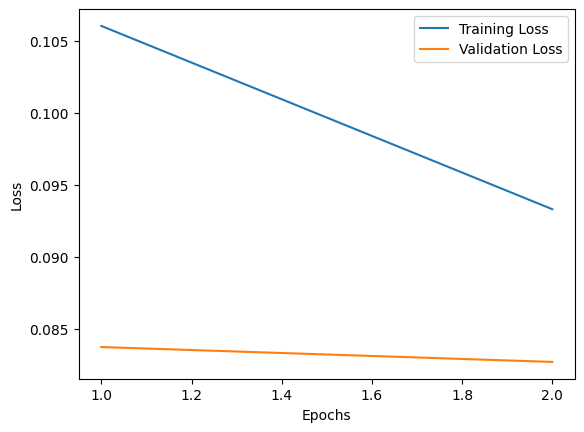

Train Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.886     0.939      6567
           1      0.878     1.000     0.935      6342
           2      1.000     0.979     0.989      6291

    accuracy                          0.954     19200
   macro avg      0.959     0.955     0.955     19200
weighted avg      0.960     0.954     0.954     19200


Validation Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.875     0.933      1647
           1      0.860     1.000     0.925      1556
           2      1.000     0.970     0.985      1597

    accuracy                          0.947      4800
   macro avg      0.953     0.948     0.948      4800
weighted avg      0.955     0.947     0.948      4800


Test Data Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.871     0.931      1966
           1      0.8

In [3]:

# Set the random seed for reproducibility


PERFORMANCE_RESULTS = pd.DataFrame(columns=['Model', 'EvalSet', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score', 'Runtime'])



for KK in list([1,100, 500, 1000, 1500]):
    
    start_time = time.time()

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
#     tf.random.set_seed(KK)



    # df = pd.read_csv('insurance_synthetic_data.csv')
    df  = pd.read_csv('../dataset/insurance_claims_data/insurance_claims.csv')
    df = df.rename(columns = {'incident_class':'label'})
    df = df.rename(columns = {'incident_description':'text'})
    # display(df)
    print("Claim Categories:", df.label.unique())


    # Divide the data into train, validation, and test sets
    train1, test = train_test_split(df, test_size=0.2, random_state=KK)
    # val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


    # Split the data into train and validation sets
    train, val = train_test_split(train1, test_size=0.2, random_state=KK)

    # Print the sizes of the datasets
    print("Training dataset size:", len(train))
    print("Validation dataset size:", len(val))
    print("Test dataset size:", len(test))


    labelencoder = LabelEncoder()
    labelencoder.fit(train['label'])
    train['encoded_label'] = labelencoder.fit_transform(train['label'])
    val['encoded_label'] = labelencoder.fit_transform(val['label'])
    test["encoded_label"] = labelencoder.transform(test['label'])
#     print("Training data Examples: ")
# #     display(train)
#     print("Validation data Examples: ")
# #     display(val)
#     print("Test data Examples: ")
# #     display(test)



    ############################################
    ## Data Preprocessing
    ############################################

    # store labels in a list 
    train_labels = torch.tensor(train["encoded_label"].tolist())
    val_labels = torch.tensor(val["encoded_label"].tolist())
    test_labels = torch.tensor(test["encoded_label"].tolist())

    # Get the text data as list of incident description 
    train_texts = train["text"].tolist()
    val_texts = val["text"].tolist()
    test_texts = test["text"].tolist()

    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")



    train_encodings = tokenizer(
        train_texts,
        padding=True,           # pad all inputs to max length
        max_length=12,         # Bert max is 512, we choose 24 for computational efficiency
        return_tensors="pt",    # Return format pytorch tensor
        truncation=True
    )

    print('train encodings shape ', train_encodings['input_ids'].shape)



    val_encodings = tokenizer(
        val_texts,
        padding=True,           # pad all inputs to max length
        max_length=12,         # Bert max is 512, we choose 24 for computational efficiency
        return_tensors="pt",    # Return format pytorch tensor
        truncation=True
    )

    print('validation encodings shape ', val_encodings['input_ids'].shape)



    test_encodings = tokenizer(
        test_texts,
        padding=True,           # pad all inputs to max length
        max_length=12,         # Bert max is 512, we choose 24 for computational efficiency
        return_tensors="pt",    # Return format pytorch tensor
        truncation=True
    )

    print('test encodings shape ', test_encodings['input_ids'].shape)




    # Convert the tokenized inputs into a PyTorch dataset (train)
    train_ds = TensorDataset(
        train_encodings["input_ids"],
        train_encodings["attention_mask"],
        train_labels  # Assuming you have the corresponding train labels
    )


    # Convert the tokenized inputs into a PyTorch dataset (validation)
    val_ds = TensorDataset(
        val_encodings["input_ids"],
        val_encodings["attention_mask"],
        val_labels  # Assuming you have the corresponding train labels
    )

    # Convert the tokenized inputs into a PyTorch dataset (test)
    test_ds = TensorDataset(
        test_encodings["input_ids"],
        test_encodings["attention_mask"],
        test_labels  # Assuming you have the corresponding train labels
    )


    # Define batch size for the train_loader and test_loader
    batch_size = 16

    # Create the train_loader
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True
    )

    # Create the val_loader
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False
    )

    #create the test loader
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False
    )



    ############################################
    ## Model Training and Performance Evaluation
    ############################################


    base_model1 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


    # Set the device for training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    # Get the GPU device on which we run our experiments
    gpu_name = torch.cuda.get_device_name(device) if device.type == 'cuda' else 'N/A'
    print("GPU Device:", gpu_name)



    model1 = base_model1.to(device)


    # Define your loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model1.parameters(), lr=5e-5)

    # Set the number of epochs and calculate the total training steps
    num_epochs = 2
    num_training_steps = num_epochs * len(train_loader)



    # Training loop
    model1.train()
    progress_bar = tqdm(total=num_training_steps)


    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_val_loss = 0.0  # Initialize validation loss

        # Training
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model1(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate the loss

            progress_bar.update(1)
    #         progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}")

        # Validation
        model1.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model1(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                epoch_val_loss += loss.item()  # Accumulate the validation loss

        avg_loss = epoch_loss / len(train_loader)  # Calculate average training loss for the epoch
        avg_val_loss = epoch_val_loss / len(val_loader)  # Calculate average validation loss for the epoch

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        train_losses.append(avg_loss)  # Append training loss to the list
        val_losses.append(avg_val_loss)  # Append validation loss to the list

    progress_bar.close()

    end_time = time.time()
    execution_time1 = end_time - start_time

    print(f"Execution time: {execution_time1} seconds")


    # Plotting
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    modname = 'BERT_base_uncased'


    # Evaluation on train data
    eval_set = "training"
    train_classification_rep = evaluate(model1, train_loader)
    results_train= export_classification_report(train_classification_rep, modname, execution_time1, eval_set)
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_train])
    print("Train Data Classification Report:")
    print(train_classification_rep)
    print()

    # Evaluation on validation data
    eval_set = "validation"
    val_classification_rep = evaluate(model1, val_loader)
    results_val=export_classification_report(val_classification_rep, modname, execution_time1, eval_set)
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_val])
    print("Validation Data Classification Report:")
    print(val_classification_rep)
    print()


    # Evaluation on test data
    eval_set = "test"
    test_classification_rep = evaluate(model1, test_loader)
    results_test=export_classification_report(test_classification_rep, modname, execution_time1, eval_set)
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_test])
    print("Test Data Classification Report:")
    print(test_classification_rep)
    print()

In [6]:
PERFORMANCE_RESULTS

,Model,EvalSet,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score,Runtime
0,BERT_base_uncased,training,0.953,0.958,0.953,0.953,0.958,0.953,0.953,160.026493
0,BERT_base_uncased,validation,0.951,0.957,0.952,0.951,0.957,0.951,0.951,160.026493
0,BERT_base_uncased,test,0.953,0.959,0.954,0.954,0.959,0.953,0.953,160.026493
0,BERT_base_uncased,training,0.953,0.958,0.953,0.953,0.958,0.953,0.953,163.119564
0,BERT_base_uncased,validation,0.951,0.956,0.952,0.951,0.957,0.951,0.951,163.119564
0,BERT_base_uncased,test,0.953,0.959,0.953,0.954,0.959,0.953,0.953,163.119564
0,BERT_base_uncased,training,0.948,0.956,0.948,0.949,0.955,0.948,0.948,178.230724
0,BERT_base_uncased,validation,0.940,0.949,0.940,0.940,0.949,0.940,0.940,178.230724
0,BERT_base_uncased,test,0.948,0.956,0.947,0.948,0.954,0.948,0.948,178.230724
0,BERT_base_uncased,training,0.955,0.956,0.955,0.955,0.955,0.955,0.955,188.006859


In [8]:
PERFORMANCE_RESULTS.to_excel(f'../result_xls/{modname}.xlsx', index=False)

## Model Evaluation 

Reference:

https://huggingface.co/docs/transformers/training

https://mccormickml.com/2019/07/22/BERT-fine-tuning/